In [2]:
#Import all packages for the Yelp Project
#Create connection to connection to created database

import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
conn = sqlite3.connect('yelp.db')
#:memory:
cur = conn.cursor()

In [3]:
#Create two variables for the business and review databases from yelp

url = 'https://api.yelp.com/v3/businesses/search'
url2 = 'https://api.yelp.com/v3/businesses/{id}/reviews'

In [4]:
#Connection to the Yelp API with the keys created 
client_id = "WdeBQ0QfW7ctlNNGDyNEwA"
api_key = "qOP1w_dBiefuyHCkz5gzIlhtKzNxBNMi3uCVJib_Kzs_y0EKqn1pKpRlpGvAPmB2fZ_eVWv65j_o5rmiT9HNK10tH5rosM3GfauVdQU0TvfOtdqn4L3zzLC2g1P3X3Yx"

In [5]:
#Gives me the information on the business using the API key
headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

In [6]:
# Created variable names that will be inputed into the API to search for the business
# The first location was for Manhattan with 10000 km radius for all business that have the keyword Yoga in it. 

term = 'yoga'
location = 'Manhattan'
radius = 10000

In [7]:
# Input thee variables just created into the URL parameters with a limit of 50 business outputted. 

url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "radius" : radius,
                "limit": 50
            }

In [8]:
# Creating of a function that intakes the url, url parameters, and API key 
# for yelp to generate information based on business

def yelp_call(url, url_params, api_key):
    # your code to make the yelp call
    response = requests.get(url, headers=headers, params=url_params)
    data = response.json()
    return data

In [9]:
#Storing all the information as a dictonary for business in NYC that pertain to yoga with a limitation of 50 businesses
# into the NYCdata dictonary variable

NYCdata = yelp_call(url, url_params, api_key)

In [10]:
# Displays the information given from the Yelp API about the yoga business in NYC 

NYCdata

{'businesses': [{'id': 'kmj7FnZsKPPH3psbR9tX7Q',
   'alias': 'sonic-yoga-new-york',
   'name': 'Sonic Yoga',
   'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/72XvEESqvzJCTA5E4o9XiA/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/sonic-yoga-new-york?adjust_creative=WdeBQ0QfW7ctlNNGDyNEwA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=WdeBQ0QfW7ctlNNGDyNEwA',
   'review_count': 146,
   'categories': [{'alias': 'yoga', 'title': 'Yoga'}],
   'rating': 4.5,
   'coordinates': {'latitude': 40.7657608, 'longitude': -73.9831765},
   'transactions': [],
   'location': {'address1': '944 8th Ave',
    'address2': 'Fl 2',
    'address3': '',
    'city': 'New York',
    'zip_code': '10019',
    'country': 'US',
    'state': 'NY',
    'display_address': ['944 8th Ave', 'Fl 2', 'New York, NY 10019']},
   'phone': '+12123976344',
   'display_phone': '(212) 397-6344',
   'distance': 731.7016468023255},
  {'id': 'GgvXfu8U80tcrxythjpB4w',
   'alias': 'atth

In [11]:
#Used SQL to created a table that will take information from the NYCdata dictonary data and input into this table
#Firtst created an empty table in which each column is identified to have either text/string, a primary key, and integer



cur.execute("""CREATE TABLE businesses (
                                id INTEGER PRIMARY KEY, 
                                businessID TEXT,
                                rating INTEGER,
                                price TEXT,
                                name TEXT,
                                review_count TEXT,
                                city TEXT,
                                country TEXT,
                                zip_code TEXT
                                )          
            """)
conn.commit()

In [12]:
#Used SQL to create an empty table to input all the reviews of the business into the reviews table


cur.execute("""CREATE TABLE reviews (
                                businessID TEXT,
                                text TEXT,
                                rating INTEGER,
                                time_created TEXT,
                                reviewID TEXT
                                )          
            """)
conn.commit()

In [13]:
# Created a function that took the infomation from the dictonary variable to fill in the empty tables created above


# Function is called parse results with the parameter results to take in 
def parse_results(results):
    # Creates an empty list called biz_list
    biz_list = []

    #Iterates through each business from the dictionary variable
    for business in results['businesses']:
        #Iteraters through each key in the dictionary to get the value to then input into the empty SQL table
        for item in ['businessID', 'rating', 'price', 'name', 'review_count', 'city', 'country', 'zip_code']:
            #If the information is missing then we input a nan value 
            if item not in business:
                #Inputs a nan value for missing value
                business[item] = np.nan
            # else input the values from the keys that have values     
            else: 
                business[item]
        biz_tuple = ( business['id'], 
                      business['rating'],
                      business['price'],
                      business['name'],
                      business['review_count'],
                      business['location']['city'],
                      business['location']['country'],
                      business['location']['zip_code']
                      )   
        # Appends the informtion from the dictonary variable to the business list 
        biz_list.append(biz_tuple)
    return biz_list

In [14]:
# Creates a function called insert_values with the parameters conn, cur, and parse_results

def insert_values(conn, cur, parse_results):
        # Creates a variable with an SQL query to insert information from the dictonary variable 
        add_business = ("""
    INSERT INTO businesses (businessID, rating, price, name, review_count, city, country, zip_code)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?) """)
        # executes the SQL query by using the variable add_business, and function parse results
        cur.executemany(add_business, parse_results)
        # Commits the SQL query 
        conn.commit()
        

In [15]:
# create a variable  to keep track of which result you are in. 
current_offset = 0
#num = NYCdata['total']
#set up a while loop to go through and grab the result 
while current_offset < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = current_offset
    #make your API call with the new offset number
    results = yelp_call(url, url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    insert_values(conn, cur, parsed_results)
    #increment the counter by 50 to move on to the next results
    current_offset += 50
    print(current_offset)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [16]:
# Creates the new location based in London dealing with yoga business 

location = 'London'

In [17]:
# Puts in the London location, same radius as we had above and the same business for our new location

url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "radius" : radius,
                "limit": 50
            }

In [18]:
# create a variable  to keep track of which result you are in. 
current_offset = 0
#num = NYCdata['total']
#set up a while loop to go through and grab the result 
while current_offset < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = current_offset
    #make your API call with the new offset number
    results = yelp_call(url, url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    insert_values(conn, cur, parsed_results)
    #increment the counter by 50 to move on to the next results
    print(current_offset)
    current_offset += 50

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [19]:
# Stores the business ID in the variable business list, executing the Fetchall statment in SQL 

biz_list = cur.execute("""
SELECT businessID
FROM businesses;
""").fetchall()

In [20]:
# Checking to make sure business ID was properly imported 

biz_list

[('kmj7FnZsKPPH3psbR9tX7Q',),
 ('GgvXfu8U80tcrxythjpB4w',),
 ('TlDcvf1cEK2im6e4AFYe3A',),
 ('npgq_up0_puDV5jieUza-A',),
 ('Oi85AYz9-Bx-9SBjNf__vg',),
 ('nuhFcWqgHBwmgwlbm4rI9w',),
 ('Chuu09nqfEQbREmaphoOuw',),
 ('FK_6tqTQuSkadiWQ1w8ttQ',),
 ('nkUwnPPYmCICZ8nYCu_twg',),
 ('XpY0Cxo_Iw2deqeY6zsNOA',),
 ('tGtrhu0YDGkM9ECrYVz6xg',),
 ('omwcHHgdgUJn-W1b3i78og',),
 ('Mc17IR6PG4iZLmZzciJEQQ',),
 ('oECxp7RoWT2QArWgqpwnMA',),
 ('x0bjd5AUu3ASzfjmht2IYA',),
 ('c_80f3N3NbWDX8RnvuM3Xg',),
 ('89VGtFw9HZASM0IdnSEeFA',),
 ('KjSI9xkCFTrRRbHOzCG7xg',),
 ('PZhmOvUx0HrdGvxVrxTJ5g',),
 ('b1ziC3xpS5Bb9PGsufBYAw',),
 ('NqL3lVZgh1pz0tVaZBxkRg',),
 ('vxNBDgBMP44E8DHuqj5z6A',),
 ('dzvqCMHOsvruyOZZ8wSnbA',),
 ('I3-EsRgXDcLx3OrlACCx3Q',),
 ('qFJcpI5TOBQkX6BukZqUVw',),
 ('6-fZD_ZzKJo29zapElbOZg',),
 ('HcsOCtxnSpAmUU0EC_AGMQ',),
 ('JvwVi-ZOfGKQEiezZTCgEA',),
 ('PISWOLCiOj47QbZKm-F3tg',),
 ('cwADiq0xORmv4QA2jhu-Pw',),
 ('fiLGdKwhkvK6pZ3E_GjHmQ',),
 ('qhjcMZivcYfr7CaTHkiXXg',),
 ('P5OZCF6xChJtWNrjNFBBRA',),
 ('gbRr9zR

In [21]:
# Creates an empty list to store to business ID's

biz_ID_list = []
# Iterates through all the bussiness ID's and index's them
for biz in biz_list:
    biz_ID = biz[0]
    biz_ID_list.append(biz_ID)
biz_ID_list

['kmj7FnZsKPPH3psbR9tX7Q',
 'GgvXfu8U80tcrxythjpB4w',
 'TlDcvf1cEK2im6e4AFYe3A',
 'npgq_up0_puDV5jieUza-A',
 'Oi85AYz9-Bx-9SBjNf__vg',
 'nuhFcWqgHBwmgwlbm4rI9w',
 'Chuu09nqfEQbREmaphoOuw',
 'FK_6tqTQuSkadiWQ1w8ttQ',
 'nkUwnPPYmCICZ8nYCu_twg',
 'XpY0Cxo_Iw2deqeY6zsNOA',
 'tGtrhu0YDGkM9ECrYVz6xg',
 'omwcHHgdgUJn-W1b3i78og',
 'Mc17IR6PG4iZLmZzciJEQQ',
 'oECxp7RoWT2QArWgqpwnMA',
 'x0bjd5AUu3ASzfjmht2IYA',
 'c_80f3N3NbWDX8RnvuM3Xg',
 '89VGtFw9HZASM0IdnSEeFA',
 'KjSI9xkCFTrRRbHOzCG7xg',
 'PZhmOvUx0HrdGvxVrxTJ5g',
 'b1ziC3xpS5Bb9PGsufBYAw',
 'NqL3lVZgh1pz0tVaZBxkRg',
 'vxNBDgBMP44E8DHuqj5z6A',
 'dzvqCMHOsvruyOZZ8wSnbA',
 'I3-EsRgXDcLx3OrlACCx3Q',
 'qFJcpI5TOBQkX6BukZqUVw',
 '6-fZD_ZzKJo29zapElbOZg',
 'HcsOCtxnSpAmUU0EC_AGMQ',
 'JvwVi-ZOfGKQEiezZTCgEA',
 'PISWOLCiOj47QbZKm-F3tg',
 'cwADiq0xORmv4QA2jhu-Pw',
 'fiLGdKwhkvK6pZ3E_GjHmQ',
 'qhjcMZivcYfr7CaTHkiXXg',
 'P5OZCF6xChJtWNrjNFBBRA',
 'gbRr9zRxpBtBLum9kMlxZw',
 'hW_eQNgyPkfwAH4Gq6I6LQ',
 'Vi_qAjnkRk4kCaMpx_-Gkg',
 'Vwy58_3fyh1LwcMCFGb5vQ',
 

In [22]:
# Creates a function that inputs the business ID to gather the reviews for each business 

def yelp_call_reviews(ID):
    
        # Takes in the url with the specific business ID 
        url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(ID)
        # takes in the url, and headers for the specific business
        response = requests.get(url, headers=headers)
        #grabs the data using the response variable and then returns the data
        data = response.json()
        return data

In [23]:
# A function created to parse the business information
# Takes in businessID and review_results parameters 

def parse_reviews(businessID, review_results):
    # Creates an empty list for the business
    tuple_lists = []
    
    # IF we have an error where no business is avaialble or their is an error we return Nan
    if 'error' in review_results:
        if review_results['error']['code'] == 'BUSINESS_UNAVAILABLE':
            return None
    
    # ELSE we then return the information regarding the reviews of the business
    else:
        # iterates over each review 
        for review in review_results['reviews']:
            # iterates each text, rating and time created for each review 
            for item in ['text', 'rating', 'time_created']:
                #if this information is not avaiable then we return a NAN value 
                if item not in review:
                    review[item] = np.nan
                    # else we return the information from each review 
                review_tuple =( businessID, 
                                review['text'],
                                review['rating'],
                                review['time_created'],
                                review['id']
                              )
                # appends it to the empty list
                tuple_lists.append(review_tuple)
    
    return tuple_lists

In [24]:
# Inserts information from the reviews list to the reviews table 

def insert_reviews(conn, cur, parse_reviews):
        add_reviews = ("""
        INSERT INTO reviews (businessID, text, rating, time_created, reviewID)
        VALUES (?, ?, ?, ?, ?) """)
        cur.executemany(add_reviews, parse_reviews)
        conn.commit()

In [25]:
# Iterates over each business ID 

for biz in biz_ID_list:
    # stores each business ID into the variable review_results using the Yelp_Call_reviews function 
    review_results = yelp_call_reviews(biz)
    # IF we get no information regarding the reviews of the business we simply just pass onto the next businees ID
    if review_results == None:
        pass
    # Using parse_review function, we intake the reviews information to parse the information into the table
    parsed_reviews = parse_reviews(biz, review_results)
    # inserts the information from the reviews from each business 
    insert_reviews(conn, cur, parsed_reviews)

In [1]:
# Executes grabbing all the information about the business to then put it into a dataframe

cur.execute("""
SELECT * FROM businesses
""")

# SQL fetchall which then puts this SQL table into a pandas dataframe
df = pd.DataFrame(cur.fetchall())
# Use the list comprehension to iterate through each business and index them
df.columns = [x[0] for x in cur.description]
# Prints out the dataframe
df

NameError: name 'cur' is not defined

In [27]:
# Executes grabbing all the information about the business reviews to then put it into a dataframe

cur.execute("""
SELECT * FROM reviews
""")
df = pd.DataFrame(cur.fetchall())
# Use the list comprehension to iterate through each business and index them
df.columns = [x[0] for x in cur.description]
# Prints out the dataframe
df

,businessID,text,rating,time_created,reviewID
0,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
1,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
2,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
3,kmj7FnZsKPPH3psbR9tX7Q,I came across Sonic Yoga on ClassPass. I have...,4,2020-02-28 06:21:41,1lBvdI7kfUrWN59njKQsZw
4,kmj7FnZsKPPH3psbR9tX7Q,I came across Sonic Yoga on ClassPass. I have...,4,2020-02-28 06:21:41,1lBvdI7kfUrWN59njKQsZw
...,...,...,...,...,...
9316,s0W-AbYi0mGw6egZ2rk_Ow,This location puts San Francisco Equinox Sport...,4,2016-08-01 12:34:31,1s1M_DJNdqHvEg2xLHChYQ
9317,s0W-AbYi0mGw6egZ2rk_Ow,This location puts San Francisco Equinox Sport...,4,2016-08-01 12:34:31,1s1M_DJNdqHvEg2xLHChYQ
9318,s0W-AbYi0mGw6egZ2rk_Ow,My father's old business partner's daughter in...,3,2018-08-08 08:30:27,sJdmd9ZYZf-BJ4SNKI-iVw
9319,s0W-AbYi0mGw6egZ2rk_Ow,My father's old business partner's daughter in...,3,2018-08-08 08:30:27,sJdmd9ZYZf-BJ4SNKI-iVw


In [29]:
# Which are the 5 most reviewed businesses?

# Executes an SQL query of the top five business 
# by selecting the name column, from business table, 
# ordering it by review count in descending order giving us a limit of 5 business
cur.execute("""
SELECT name 
FROM businesses
ORDER By review_count DESC
LIMIT 5
""").fetchall()

[('Brooklyn Boulders',),
 ('Peloton',),
 ('iLoveKickboxing- Chelsea NYC',),
 ('Exhale Central Park South',),
 ('Pop Physique',)]

In [30]:
#What is the highest rating recieved in your data set and how many businesses have that rating?

# Executes an SQL query of the highest rating and which business have the highest rating
# by selecting th rating, and th count of those rates, from the business table
# Where rating equals thee max rating from the business table 
cur.execute("""
SELECT rating, COUNT(rating)
FROM businesses
WHERE rating = (SELECT MAX(rating) FROM businesses)
""").fetchall()

[(5, 528)]

In [31]:
# What percentage of businesses have a rating greater than or 4.5?

#Executed an SQL query to find out the amount of businesses that had a rating greater than 
# 4.5% 

# Selected all the businesses with a rating 4.5 and higher and counted them then multiplied by 100 to then 
# divide by the total number of business

cur.execute("""
SELECT
COUNT(*)*100/ (SELECT COUNT(*) FROM businesses)
FROM businesses 
WHERE rating < 4.5
""").fetchall()

[(32,)]

In [32]:
# What percentage of businesses have a rating less than 3?

# Exectuted the percentage of businesses with a rating less than 3

# Found a count of the businesses who had a rating less than 3 rating, multiplied by 100 then dividied
# the total number of business 

cur.execute("""
SELECT
COUNT(*)*100/ (SELECT COUNT(*) FROM businesses)
FROM businesses 
WHERE rating < 3
""").fetchall()

[(3,)]

In [33]:
# What is the average rating of businesses that have a price label of one dollar sign? 
# Two dollar signs? Three dollar signs?


# Exectued an SQL query to find the average rating of businesses with a one dollar sign, 
# two dollar signs, and three dollar signs 

# Selectd the average rating and aliased it average rating, as well as price
# From the business table, and grouped by price
# Having the criteria of "$", "$$", "$$$" dollar signs

cur.execute("""
SELECT AVG(rating) AS AvgRating, price
FROM businesses
GROUP BY price
HAVING price = '$' OR price = '$$' OR price = '$$$'
""").fetchall()

[(4.25, '$'), (4.1923076923076925, '$$'), (3.4516129032258065, '$$$')]

In [34]:
#Return the text of the reviews for the most reviewed business.

# Executed an SQL query to see what people said about the most reviewed business

# Selected the text from the reviews table 
# Where we I did a subtable using the primary key businessID from business table 
# to select the businessID to order the review count with a limit of one review per business

cur.execute("""
SELECT text
FROM reviews
WHERE businessID in (SELECT businessID
                     FROM businesses
                     ORDER BY review_count
                     LIMIT 1
                     );
""").fetchall()

[('I came away very impressed after some session stress management and yoga sessions with Eiji. His calm demeanor and clear instructions made it a very easy to...',),
 ('I came away very impressed after some session stress management and yoga sessions with Eiji. His calm demeanor and clear instructions made it a very easy to...',),
 ('I came away very impressed after some session stress management and yoga sessions with Eiji. His calm demeanor and clear instructions made it a very easy to...',)]

In [35]:
# Return the name of the business with the most recent review.

# Executed a SQL query to find the name of the business with most recent review
# Selected the name from the business table where the businessID from the reviews
# table was given which I ordered by the time the review was created in descending order
# with a limit of one

cur.execute("""
SELECT name
FROM businesses
WHERE businessID in (SELECT businessID
                     FROM reviews
                     ORDER BY time_created DESC
                     LIMIT 1);

""").fetchall()

[('Five Pillars Yoga',)]

In [40]:
# Find the highest rated business and return text of the most recent review. 
# If multiple business have the same rating, select the business with the most reviews.


# selected the text from the business table, and aliased the reviews table as r
# and did an inner join with the business table as b using the businessID as the 
# primary key which I orderd by review count in descending order and rating in descending order
# with a limit of one 

cur.execute("""
SELECT text
FROM reviews AS r
JOIN businesses AS b
ON r.businessID = b.businessID
ORDER BY review_count DESC, b.rating DESC
LIMIT 1
""").fetchall()

[("Absolutely enjoyed my time at the flagship location. I totally forgot the associate's name, but he was very helpful in selling me my first pair of...",)]

In [41]:
# Find the lowest rated business and return text of the most recent review. 
# If multiple business have the same rating, select the business with the least reviews.

# Selected the text from reviews, and aliased reviews table as r 
# then did an inner join on businesses table as b using the primary key businessID
# then ordered by rating in ascending order and review count in ascending order
# with a limit of one

cur.execute("""
SELECT text
FROM reviews AS r
JOIN businesses AS b
ON r.businessID = b.businessID
ORDER BY  b.rating ASC, review_count ASC
LIMIT 1
""").fetchall()

[('Participated in a photo shoot for this studio way back in 2018, and was promised TFP not long after. 2 years and multiple failed contact attempts later,...',)]

In [42]:
cur.execute("""
SELECT * FROM businesses
""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,id,businessID,rating,price,name,review_count,city,country,zip_code
0,1,kmj7FnZsKPPH3psbR9tX7Q,4.5,None,Sonic Yoga,146,New York,US,10019
1,2,GgvXfu8U80tcrxythjpB4w,5.0,None,AtthenaYoga,42,New York,US,10036
2,3,TlDcvf1cEK2im6e4AFYe3A,4.5,None,Humming Puppy,90,New York,US,10011
3,4,npgq_up0_puDV5jieUza-A,4.5,None,Yo Yoga!,55,New York,US,10022
4,5,Oi85AYz9-Bx-9SBjNf__vg,4.5,None,Yoga Spa Lounge 1881,92,New York,US,10022
...,...,...,...,...,...,...,...,...,...
1174,1175,XCOdN4pGetfR8Ema258z3w,2.5,None,DW FITNESS,7,London,GB,WC2B 4DD
1175,1176,Q-nSJQDBRyn9Ahqc4oRlRg,3.5,None,Fitness First Broadgate,3,London,GB,EC2M 7PY
1176,1177,MEUESxTbldQnKrU7_9g4Yw,4.0,None,Mettá,1,London,GB,NW5 1NA
1177,1178,zI399ArMHUW9uDNkTciDPA,3.5,None,Virgin Active,9,London,GB,SW4 0HG


In [43]:
cur.execute("""
SELECT * FROM reviews
""")
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1

,businessID,text,rating,time_created,reviewID
0,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
1,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
2,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
3,kmj7FnZsKPPH3psbR9tX7Q,I came across Sonic Yoga on ClassPass. I have...,4,2020-02-28 06:21:41,1lBvdI7kfUrWN59njKQsZw
4,kmj7FnZsKPPH3psbR9tX7Q,I came across Sonic Yoga on ClassPass. I have...,4,2020-02-28 06:21:41,1lBvdI7kfUrWN59njKQsZw
...,...,...,...,...,...
9316,s0W-AbYi0mGw6egZ2rk_Ow,This location puts San Francisco Equinox Sport...,4,2016-08-01 12:34:31,1s1M_DJNdqHvEg2xLHChYQ
9317,s0W-AbYi0mGw6egZ2rk_Ow,This location puts San Francisco Equinox Sport...,4,2016-08-01 12:34:31,1s1M_DJNdqHvEg2xLHChYQ
9318,s0W-AbYi0mGw6egZ2rk_Ow,My father's old business partner's daughter in...,3,2018-08-08 08:30:27,sJdmd9ZYZf-BJ4SNKI-iVw
9319,s0W-AbYi0mGw6egZ2rk_Ow,My father's old business partner's daughter in...,3,2018-08-08 08:30:27,sJdmd9ZYZf-BJ4SNKI-iVw


In [44]:
# Created an SQL query grabbing the rating and city
# from businesses and grouped by country to create a data visualization 
# of the number of yoga businesses with a rating higher than 4

Avg_Country = cur.execute("""
SELECT rating, city
FROM businesses
GROUP BY country 
""").fetchall()

In [47]:
# Created a variable that grouped country and average rating to display in a visual bar plot

Avg_Country = df.groupby('country')['rating'].mean()

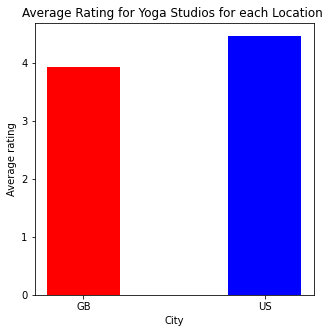

In [48]:
#Using matplot lib created a subplot with figsize 5 by 5 

fig, ax = plt.subplots(figsize=(5, 5))

# bar plot labels country on the X axis, and average rating on the Y axis
ax.bar(Avg_Country.index, Avg_Country.values, color = ('Red', 'blue'), width = 0.4)

# labeling of axis and title 
ax.set_xlabel("City")
ax.set_ylabel("Average rating")
ax.set_title("Average Rating for Yoga Studios for each Location ")
plt.show()

In [49]:
# Created a SQL query grabbing the city, rating, and review count
# From the business table with a group by of the country 

cur.execute("""
SELECT city, rating, review_count
FROM businesses
GROUP BY country
""")

# Puts the query into a pandas dataframe to then plot later 
avgR = pd.DataFrame(cur.fetchall())
avgR.columns = [x[0] for x in cur.description]
avgR

,city,rating,review_count
0,London,5.0,1
1,New York,4.5,146


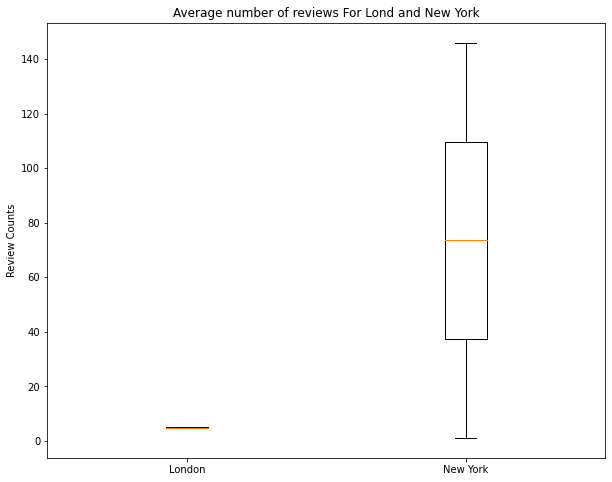

In [50]:
# Created a subplot with figure size of 10 by 8 

fig, ax = plt.subplots(figsize = (10,8))

#created a box plot with rating vs review_count to check for mean, median and mode of the number of reviews 
ax.boxplot([avgR.rating, avgR.review_count])

# Set the x-axis label to Countries the reviews came from "
ax.set_xticklabels(['London', "New York"])

# Set the y-axis label to the number of reviews, the average reviews, most reviews and the middle number of review"
ax.set_ylabel("Review Counts")

ax.set_title('Average number of reviews For Lond and New York')


plt.show()

In [51]:
# Created an SQL query that selected the price, city, and review count 
# from each busineess where prices ranged from most expensive to least 
# expensive 


cur.execute("""
SELECT price, city, review_count
FROM businesses 
WHERE price = '$$$$' OR price = '$$$' OR price = '$$' OR price = '$'
""")

# Put this query into a dataframe to visualize 
priceNYCdb = pd.DataFrame(cur.fetchall())
priceNYCdb.columns = [x[0] for x in cur.description]
priceNYCdb

,price,city,review_count
0,$$,New York,10
1,$$,New York,1
2,$$,Jersey City,40
3,$$$,New York,269
4,$$$,Guttenberg,38
5,$$,New York,9
6,$$$,New York,105
7,$$$,New York,12
8,$$,New York,4
9,$,New York,138


In [52]:
#Created an empty list called new column 


newcolumn = []

# Iterated through the each businesses price 
for x in priceNYCdb['price']:
    # IF they had a price of '$' then that price was replace with integer of 1 
    if x == '$':
        newcolumn.append(int(x.replace('$', str(1))))
    # IF they had a price of '$' then that price was replace with integer of 2     
    if x == '$$':
        newcolumn.append(int(x.replace('$$', str(2))))
    # IF they had a price of '$' then that price was replace with integer of 3
    if x == '$$$':
        newcolumn.append(int(x.replace('$$$', str(3))))
    # IF they had a price of '$' then that price was replace with integer of 4
    if x == '$$$$':
        newcolumn.append(int(x.replace('$$$$', str(4))))

In [53]:
# Took a the list of price values and made a new column to then visualize later

priceNYCdb['newPrice'] = newcolumn

In [54]:
# Executed and SQL query that grabbed the pricing for yoga studios in London 

cur.execute("""
SELECT price, city, review_count
FROM businesses 
WHERE price = '££££' OR price = '£££' OR price = '££' OR price = '£'

""")

# Put the pricing information into a pandas dataframe 
priceUKdb = pd.DataFrame(cur.fetchall())
priceUKdb.columns = [x[0] for x in cur.description]
priceUKdb

,price,city,review_count
0,££,London,8
1,£££,London,7
2,£££,Soho,15
3,££,London,5
4,£££,London,2
5,££,London,6
6,££££,London,7
7,£££,London,4
8,££,London,2
9,££££,London,2


In [55]:
#Created an empty list called new column

newcolumnUK = []

# Iterated through the each businesses price
for x in priceUKdb['price']:
    
    # IF they had a price of '£' then that price was replace with integer of 1 
    if x == '£':
        newcolumnUK.append(int(x.replace('£', str(1))))
    # IF they had a price of '£' then that price was replace with integer of 2
    if x == '££':
        newcolumnUK.append(int(x.replace('££', str(2))))
    # IF they had a price of '£' then that price was replace with integer of 3
    if x == '£££':
        newcolumnUK.append(int(x.replace('£££', str(3))))
    # IF they had a price of '£' then that price was replace with integer of 4
    if x == '££££':
        newcolumnUK.append(int(x.replace('££££', str(4))))

In [56]:
# Took these new values and appended them to the column New Price 
priceUKdb['newPrice'] = newcolumnUK 

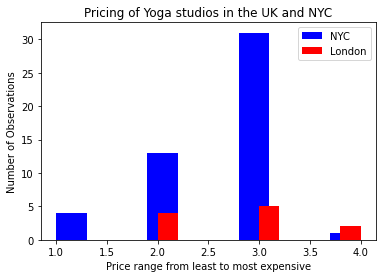

In [57]:

# Created a subplot with autfill figure size 

fig, ax = plt.subplots()

# Plot a histogram of "NYC" 
ax.hist(priceNYCdb['newPrice'], label = 'NYC',  color = 'blue')

# Compare to histogram of "London"
ax.hist(priceUKdb['newPrice'], label= 'London', color = 'red')

# Set the x-axis label to "Price Range" from 1 to 4 
ax.set_xlabel('Price range from least to most expensive')

# Set the y-axis label to "# of observations"
ax.set_ylabel('Number of Observations')

ax.set_title('Pricing of Yoga studios in the UK and NYC')

ax.legend()
plt.show()

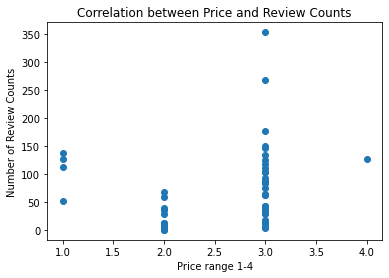

In [58]:
# Created a subplot with autofill figure size 

fig, ax = plt.subplots()

# Add data: "Price", "Review Count" as x-y, index as color
ax.scatter(priceNYCdb["newPrice"], priceNYCdb["review_count"])

# Set the x-axis label to "Price Range (1-4)"
ax.set_xlabel("Price range 1-4")

# Set the y-axis label to "Number of Reviews"
ax.set_ylabel("Number of Review Counts")

ax.set_title('Correlation between Price and Review Counts')


plt.show()